In [1]:
import os
import sys
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Compare baseline models

## Load global parameters

In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [3]:
from pipelines.baseline_config import DATA_PATH, MAIN_PATH, DATASETS, SCALERS

In [5]:
# TODO: hack
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_scalers'
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_bias_reg'
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_bias_reg_insteps=2'
# MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_diff_scalers'
MAIN_PATH = MAIN_PATH.parents[0] / 'baseline_diff_bias_reg'

In [6]:
MODELS = ['mlp-diff', 'naive']  # baseline models
INPUT_TYPES = ['supervised', 'sequential']
PLOT_PATH = MAIN_PATH / "plots"
PLOT_PATH.mkdir(parents=True, exist_ok=True)
INPUT_FEATURES = 166

# Scalar heatmaps

## Load results

#### Based on name

In [6]:
# data = {}
# for model in MODELS:
#     for input_type in INPUT_TYPES:
#         for scaler in SCALERS:
#             for train_dataset in DATASETS:
#                 name = f"{model}_{input_type}_{scaler}_{train_dataset}"
#                 data[f"{name}_{train_dataset}"] = json.load(open(MAIN_PATH / name / 'scores' / f'{train_dataset}_train.json', 'r'))
#                 data[f"{name}_{train_dataset}_val"] = json.load(open(MAIN_PATH / name / 'scores' / f'{train_dataset}_val.json', 'r'))
#                 for dataset in DATASETS:
#                     if dataset != train_dataset:
#                         data[f"{name}_{dataset}"] = json.load(open(MAIN_PATH / name / 'scores' / f'{dataset}.json', 'r'))

#### Based on file content

In [70]:
data = {}
for path in (MAIN_PATH).iterdir():
    # ------ hack starts
    # 1) Select all data folders
    if path.name in ['plots', 'log', '.ipynb_checkpoints']:
        continue
    # 2) Scaler name may contain more than one word
    # Unfortunately, the same separator is used
    try:
        name = [path.name.replace(s, s.replace('_', '-')) for s in
                SCALERS if s in path.name][0]
    except:
        name = path.name
    # 3) Model name may contain more than one word
    elements = name.replace('mlp_diff', 'mlp-diff').split('_')
    # ------ hack ends
    (model, input_type, scaler, train_dataset), kwargs = elements[:4], "_".join(elements[5:])
    if kwargs:
        kwargs += '_'
    name = f"{model}_{input_type}_{scaler}_{kwargs}_{train_dataset}"
    # names.append(f"{model}_{input_type}_{scaler}".replace('-', '_'))
    data[f"{name}_{train_dataset}"] = json.load(open(MAIN_PATH / path.name / 'scores' / f'{train_dataset}_train.json', 'r'))
    data[f"{name}_{train_dataset}_val"] = json.load(open(MAIN_PATH / path.name / 'scores' / f'{train_dataset}_val.json', 'r'))
    for dataset in DATASETS:
        if dataset != train_dataset:
            data[f"{name}_{dataset}"] = json.load(open(MAIN_PATH / path.name / 'scores' / f'{dataset}.json', 'r'))

## Create arrays

In [8]:
arrays = {'Spearman mean': {},
          'Spearman std': {},
          'Spearman NaNs': {},
          'NRMSE mean': {},
          'NRMSE std': {},
          'NRMSE NaNs': {},
          'Bray-Curtis mean': {},
          'Bray-Curtis std': {},
          'Procrustis': {},
         }

# each measure computed as mean over bacteria
# Spearman number of predicted:
#   - TOTAL - zero response from model or expected is zero (one of two vectors is constant)
# NRMSE total - false positives:
#   - TOTAL - nonzero response when we expect zeros (false positive)

# for model in MODELS:
#     for input_type in INPUT_TYPES:
#         for scaler in SCALERS:
for name in set(k.split('__')[0] for k in data.keys()):
    # empty arrays
    tmp = dict(zip(arrays.keys(), [np.zeros([4,5]) for i in range(len(arrays))]))
    for i, d1 in enumerate(DATASETS):
        # validation
        datum = data[f"{name}__{d1}_{d1}_val"]
        tmp['Spearman mean'][i, 0] = datum['spearman'][0]
        tmp['Spearman std'][i, 0] = datum['spearman'][1]
        tmp['Spearman NaNs'][i, 0] = INPUT_FEATURES - datum['spearman'][2]
        tmp['NRMSE mean'][i, 0] = 1 / datum['nrmse'][0]
        tmp['NRMSE std'][i, 0] = 1 / datum['nrmse'][1]
        tmp['NRMSE NaNs'][i, 0] = INPUT_FEATURES - datum['nrmse'][2]
        tmp['Bray-Curtis mean'][i, 0] = 1 - datum['inter'][0]
        tmp['Bray-Curtis std'][i, 0] = 1 - datum['inter'][1]
        tmp['Procrustis'][i, 0] = 1 - datum['intra']
        # train / test
        for j, d2 in enumerate(DATASETS):
            datum = data[f"{name}__{d1}_{d2}"]
            tmp['Spearman mean'][i, j+1] = datum['spearman'][0]
            tmp['Spearman std'][i, j+1] = datum['spearman'][1]
            tmp['Spearman NaNs'][i, j+1] = INPUT_FEATURES - datum['spearman'][2]
            tmp['NRMSE mean'][i, j+1] = 1 / datum['nrmse'][0]
            tmp['NRMSE std'][i, j+1] = datum['nrmse'][1]
            tmp['NRMSE NaNs'][i, j+1] = INPUT_FEATURES - datum['nrmse'][2]
            tmp['Bray-Curtis mean'][i, j+1] = 1 - datum['inter'][0]
            tmp['Bray-Curtis std'][i, j+1] = datum['inter'][1]
            tmp['Procrustis'][i, j+1] = 1 - datum['intra']
    # array
    arrays['Spearman mean'][name] = tmp['Spearman mean'] 
    arrays['Spearman std'][name] = tmp['Spearman std'] 
    arrays['Spearman NaNs'][name] = tmp['Spearman NaNs'] 
    arrays['NRMSE mean'][name] = tmp['NRMSE mean'] 
    arrays['NRMSE std'][name] = tmp['NRMSE std'] 
    arrays['NRMSE NaNs'][name] = tmp['NRMSE NaNs'] 
    arrays['Bray-Curtis mean'][name] = tmp['Bray-Curtis mean'] 
    arrays['Bray-Curtis std'][name] = tmp['Bray-Curtis std'] 
    arrays['Procrustis'][name] = tmp['Procrustis'] 

In [9]:
kwargs = {'cmap': "YlGnBu", 'linewidth': 0.5,
          'xticklabels': ['validation', 'donorA', 'donorB', 'male', 'female'],
          'yticklabels': ['donorA', 'donorB', 'male', 'female'],
         }
plot_params = {'Spearman mean': {'label': 'Spearman coefficient', 'vmin': 0, 'vmax': 1},
               'NRMSE mean': {'label': '1 / NRMSE', 'vmin': 0, 'vmax': 'computed'},
               'Spearman NaNs': {'label': 'Spearman total - (false positives + false negatives)', 'vmin': 'computed', 'vmax': INPUT_FEATURES},
               'NRMSE NaNs': {'label': 'NRMSE total - false positives', 'vmin': 'computed', 'vmax': INPUT_FEATURES},
               'Bray-Curtis mean': {'label': 'Bray-Curtis similarity', 'vmin': 0, 'vmax': 1},
               'Procrustis': {'label': 'Procrustis similarity', 'vmin': 0, 'vmax': 1},
         }

### Example

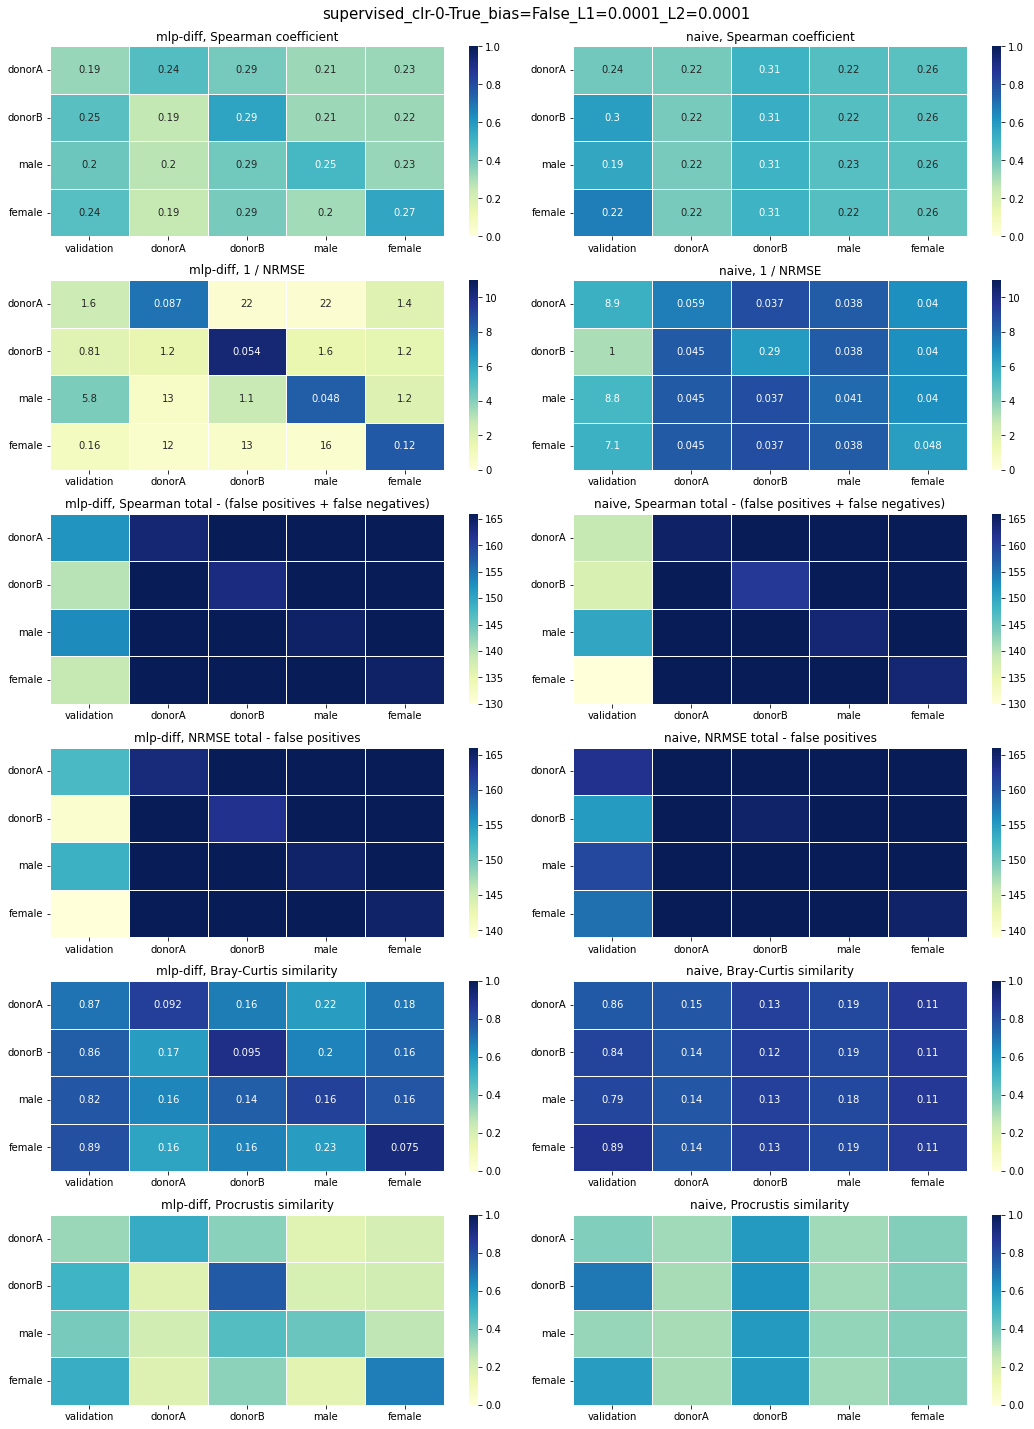

In [10]:
# name = "supervised_clr-0-True"
name = 'supervised_clr-0-True_bias=False_L1=0.0001_L2=0.0001'
plt.figure(figsize=(15,20))
for i, (k, v) in enumerate(plot_params.items()):
    plt.subplot(len(plot_params), 2, 2*i+1)
    # NRMSE mean / NaNs can be very different
    merged = np.concatenate([arrays[k][f'{MODELS[0]}_{name}'], arrays[k][f'{MODELS[1]}_{name}']])
    if v['vmax'] == 'computed':
        vmax = np.ceil(np.max(merged))
    else:
        vmax = v['vmax']
    # NRMSE NaNs can be very different
    if v['vmin'] == 'computed':
        vmin = np.min(merged)
    else:
        vmin = v['vmin']
    if 'mean' in k:
        annot_mlp = arrays[k.replace('mean', 'std')][f'{MODELS[0]}_{name}']
        annot_naive = arrays[k.replace('mean', 'std')][f'{MODELS[1]}_{name}']
    else:
        annot_mlp, annot_naive = None, None
    ax = sns.heatmap(arrays[k][f'{MODELS[0]}_{name}'], annot=annot_mlp, vmin=vmin, vmax=vmax, **kwargs)
    ax.tick_params(axis='y', rotation=0)
    ax.set_title(f'{MODELS[0]}, {v["label"]}')
    plt.subplot(len(plot_params), 2, 2*i+2)
    ax = sns.heatmap(arrays[k][f'{MODELS[1]}_{name}'], annot=annot_naive, vmin=vmin, vmax=vmax, **kwargs)
    ax.tick_params(axis='y', rotation=0)
    ax.set_title(f'{MODELS[1]}, {v["label"]}')
plt.suptitle(name, fontsize=15, y=0.99)
plt.tight_layout()
# plt.savefig(PLOT_PATH / f"{name}.png", dpi=200, facecolor='white')
plt.show()

### Loop

In [68]:
# for input_type in INPUT_TYPES:
#     for scaler in SCALERS:
#         name = f"{input_type}_{scaler}"
names = set("_".join(re.sub('(__).*', '', k).split('_')[1:]) for k in data.keys())
for count, name in enumerate(names):
    plt.figure(figsize=(15,20))
    for i, (k, v) in enumerate(plot_params.items()):
        plt.subplot(len(plot_params), 2, 2*i+1)
        # NRMSE mean / NaNs can be very different
        merged = np.concatenate([arrays[k][f'{MODELS[0]}_{name}'], arrays[k][f'{MODELS[1]}_{name}']])
        if v['vmax'] == 'computed':
            vmax = np.ceil(np.max(merged))
        else:
            vmax = v['vmax']
        # NRMSE NaNs can be very different
        if v['vmin'] == 'computed':
            vmin = np.min(merged)
        else:
            vmin = v['vmin']
        if 'mean' in k:
            annot_mlp = arrays[k.replace('mean', 'std')][f'{MODELS[0]}_{name}']
            annot_naive = arrays[k.replace('mean', 'std')][f'{MODELS[1]}_{name}']
        else:
            annot_mlp, annot_naive = None, None
        ax = sns.heatmap(arrays[k][f'{MODELS[0]}_{name}'], annot=annot_mlp, vmin=vmin, vmax=vmax, **kwargs)
        ax.tick_params(axis='y', rotation=0)
        ax.set_title(f'{MODELS[0]}, {v["label"]}')
        plt.subplot(len(plot_params), 2, 2*i+2)
        ax = sns.heatmap(arrays[k][f'{MODELS[1]}_{name}'], annot=annot_naive, vmin=vmin, vmax=vmax, **kwargs)
        ax.tick_params(axis='y', rotation=0)
        ax.set_title(f'{MODELS[1]}, {v["label"]}')
    plt.suptitle(name, fontsize=15, y=0.99)
    plt.tight_layout()
    plt.savefig(PLOT_PATH / f"{name}.png", dpi=200, facecolor='white')
    print(f"Done: {count+1} / {len(names)}", end='\r')
    plt.close()

# Vector plots

Analyse specific combination deeper looking at change in scores:
- over time (`f1_score`, `inter`) 
- over bacteria (`Spearman`, `NRMSE`)

In [139]:
mname = 'mlp_diff'
# intype = 'supervised'
intype = 'sequential'
scaler = 'clr_0_True'
trainset = 'male'
# kwargs = 'use_bias=False_L1=0.0001_L2=0.0001'
kwargs = 'use_input_bias=True_use_pred_bias=True_input_L1=0.001_input_L2=0.001_pred_L1=0_pred_L2=0'
score = 'nrmse'  # score we want to analyse
model_path = MAIN_PATH / f"{mname}_{intype}_{scaler}_{trainset}_{kwargs}" / "scores"
ref_path = MAIN_PATH / f"naive_{intype}_{scaler}_{trainset}_{kwargs}" / "scores"

### Load data

In [140]:
data_vec = {}
data_ref_vec = {}
for d in DATASETS:
    if d == trainset:
        data_vec[f"{d}_train"] = pd.read_csv(model_path / f'{trainset}_train_{score}.csv', index_col=0)
        data_vec[f"{d}_val"] = pd.read_csv(model_path / f'{trainset}_val_{score}.csv', index_col=0)
        data_ref_vec[f"{d}_train"] = pd.read_csv(ref_path / f'{trainset}_train_{score}.csv', index_col=0)
        data_ref_vec[f"{d}_val"] = pd.read_csv(ref_path / f'{trainset}_val_{score}.csv', index_col=0)
    else:
        data_vec[d] = pd.read_csv(model_path / f'{d}_{score}.csv', index_col=0)
        data_ref_vec[d] = pd.read_csv(ref_path / f'{d}_{score}.csv', index_col=0)

In [141]:
assert data_vec.keys() == data_ref_vec.keys()

### Plots

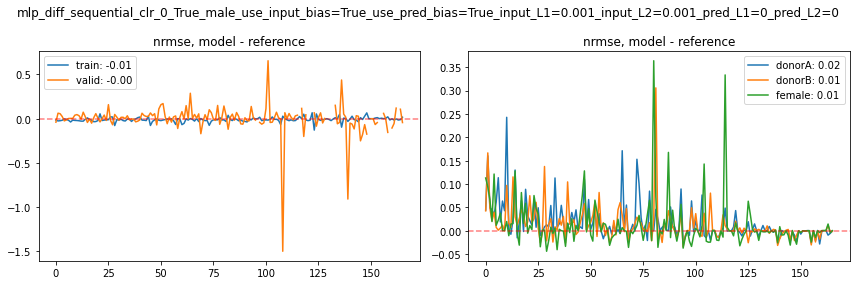

In [142]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# take difference wrt the reference (naive)
tmp_t = data_vec[f"{trainset}_train"] -  data_ref_vec[f"{trainset}_train"]
tmp_v = data_vec[f"{trainset}_val"] -  data_ref_vec[f"{trainset}_val"]
plt.plot(range(len(tmp_t)), tmp_t, label=f"train: {tmp_t.mean()[0]:.2f}")
plt.plot(range(len(tmp_v)), tmp_v, label=f"valid: {tmp_v.mean()[0]:.2f}")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title(f"{score}, model - reference")
plt.legend()
plt.subplot(1, 2, 2)
for d in [d for d in DATASETS if d != trainset]:
    # take difference wrt the reference (naive)
    tmp_test = data_vec[d] - data_ref_vec[d]
    plt.plot(range(len(tmp_test)), tmp_test, label=f"{d}: {tmp_test.mean()[0]:.2f}")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.title(f"{score}, model - reference")
plt.suptitle(f"{mname}_{intype}_{scaler}_{trainset}_{kwargs}")
plt.tight_layout()
plt.show()